# Задание по современным методам компьютерного зрения

## Тема: "Fine-tuning и анализ внимания в Vision Transformer" ##
## Студент: Шайдуров Даниил Сергеевич ## 


In [7]:
import torch
from transformers import ViTImageProcessor
from datasets import load_dataset
import numpy as np
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter, Compose
import evaluate 
import matplotlib.pyplot as plt

# Подготовка данных и fine-tuning ViT

In [ ]:
from transformers import ViTImageProcessor
from torchvision import transforms
from datasets import load_dataset
import torch

def get_data_loaders(batch_size=32):
    dataset = load_dataset("cifar10")

    # Используем процессор от предобученной модели
    processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

    # Определяем трансформации
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
    ])

    def preprocess_train(example_batch):
        example_batch['pixel_values'] = [train_transforms(image.convert('RGB')) for image in example_batch['img']]
        return example_batch

    def preprocess_val(example_batch):
        example_batch['pixel_values'] = [val_transforms(image.convert('RGB')) for image in example_batch['img']]
        return example_batch

    # Применяем трансформации и устанавливаем формат для PyTorch
    train_dataset = dataset['train'].with_transform(preprocess_train)
    split_dataset = train_dataset.train_test_split(test_size=0.1, seed=42)
    train_ds = split_dataset['train']
    val_ds = split_dataset['test']
    test_ds = dataset['test'].with_transform(preprocess_val)

    # Создаем DataLoader
    train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader, dataset['test'].features['label'].names

In [8]:
# Загружаем датасет CIFAR-10
dataset = load_dataset('cifar10')

In [9]:
# Создаем отдельные тестовую и валидационную выборки
split = dataset['train'].train_test_split(test_size=0.1, seed=42)
train_ds = split['train']
val_ds = split['test']  # Это валидационная выборка
test_ds = dataset['test']  # Это тестовая выборка

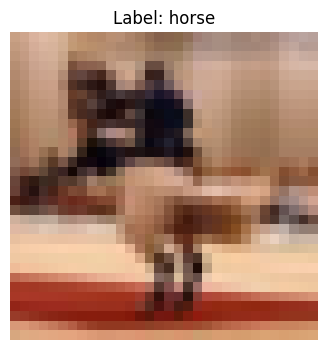

In [10]:
sample = dataset['train'][255]

img = sample['img']
label = sample['label']
classes = dataset['train'].features['label'].names

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f'Label: {classes[label]}')
plt.axis('off')
plt.show()

In [11]:
type(img)

PIL.PngImagePlugin.PngImageFile

In [12]:
# Загружаем процессор для предобученной модели ViT
model_name = 'google/vit-base-patch16-224'
processor = ViTImageProcessor.from_pretrained(model_name)

In [13]:
# Определяем аугментации для тренировочной выборки
train_transforms = Compose([
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    RandomRotation(degrees=10),
])

In [14]:
def transform_train(examples):
    # ViT ожидает изображения в формате PIL
    images = [image.convert('RGB') for image in examples['img']]
    # Применяем аугментации
    images = [train_transforms(image) for image in images]
    # Применяем стандартный процессор ViT (изменение размера, нормализация)
    inputs = processor(images=images, return_tensors='pt')
    inputs['labels'] = examples['label']
    return inputs

In [15]:
def transform_val(examples):
    images = [image.convert('RGB') for image in examples['img']]
    inputs = processor(images=images, return_tensors='pt')
    inputs['labels'] = examples['label']
    return inputs

In [16]:
# Применяем трансформации к датасетам
train_ds.set_transform(transform_train)
val_ds.set_transform(transform_val)
test_ds.set_transform(transform_val)

In [17]:
print(f"Размер тренировочной выборки: {len(train_ds)}")
print(f"Размер валидационной выборки: {len(val_ds)}")
print(f"Размер тестовой выборки: {len(test_ds)}")

Размер тренировочной выборки: 45000
Размер валидационной выборки: 5000
Размер тестовой выборки: 10000


# Реализация модели и обучения

In [18]:
from transformers import ViTForImageClassification, TrainingArguments, Trainer

In [19]:
# Загружаем метрику accuracy из библиотеки evaluate
accuracy_metric = evaluate.load("accuracy")

In [20]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)



In [21]:
# Загружаем предобученную модель ViT
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=10,
    ignore_mismatched_sizes=True  # Игнорируем несовпадение размера головы классификатора
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# Определяем гиперпараметры обучения
training_args = TrainingArguments(
    output_dir='./vit-base-cifar10-results',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    logging_steps=10,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to=None,
    dataloader_pin_memory=False,
    remove_unused_columns=False,
    save_total_limit=2,
)

In [32]:
# Создаем Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)


/tmp/ipykernel_370665/2527621201.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [33]:
import gc

# Очистка памяти
torch.cuda.empty_cache()
gc.collect()

# Проверка свободной памяти
print(f"Свободно памяти: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

Свободно памяти: 0.33 GB


In [34]:
# Запускаем fine-tuning!
print("Начинаем обучение...")
train_results = trainer.train()
print("Обучение завершено!")

# Сохраняем модель
trainer.save_model()
trainer.save_state()

Начинаем обучение...


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 